# Summary

| algorithm | accuracy | recall | time |
| --- | --- | --- | --- |
| bg from gt | 0.9431 | 0.9650 | .500 |
| fg + bg from gt | 0.9544 | 0.9787 | ~ |
| custom | 0.9509 | 0.9729 | ~ |
| custom + eyes,face | 0.9522 | 0.9724 | .570 |
| custom + saliency 0.2/0.5 (PF/F) | 0.9326 | 0.9848 | .525 |
| custom + saliency 1.0/0.5 (PF/F) | 0.9391 | 0.9840 | ~ |
| custom + saliency 0.6/1.0 (PF/F) | 0.9534 | 0.9716 | ~ |
| custom + saliency 0.6/1.0 (PF/F) | 0.9534 | 0.9716 | ~ |
| custom + saliency 0.6/1.0 (PF/F) + eyes,face | 0.9531 | 0.9736 | .605 |
| unet | 0.9754 | 0.9649 | .486 |
| custom + unet | 0.9800 | 0.9751 | .848 |

In [1]:
from fastai import *
from fastai.vision import *
from pathlib import Path
import cv2

In [3]:
path = Path('data/')
path_lbl = path/'labels'
path_img = path/'images'
path_poly = path/'polys'

### prep

In [4]:
def find_image(file_path):
    for im_path in path_img.iterdir():
        if im_path.stem == file_path.stem: return im_path
    raise Exception(f'No {file_path} image')

def read_polys(json_path):
    data = json.load(open(json_path))['shapes'][0]
    return data['label'], np.array(data['points'], dtype=int) # [N,2] shape

def convert_polys_to_segmentation():
    for json_path in progress_bar(list(path_poly.iterdir())):
        im_path = find_image(json_path)
        im = cv2.imread(str(im_path))
        lbl, polys = read_polys(json_path)
        mask = np.zeros(im.shape[:2], dtype=np.float32)
        mask = cv2.fillPoly(mask, [polys.reshape((-1,1,2))], (255,255,255))
        out_path = path_lbl/(json_path.stem+'.png')
        seg = ImageSegment(tensor(mask)[None] / 255.)
        seg.save(out_path)
    #     seg.show()

In [5]:
# convert_polys_to_segmentation()

### helper funcs

In [6]:
get_y_fn = lambda x: path_lbl/f'{x.stem}.png'

In [7]:
img_names = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

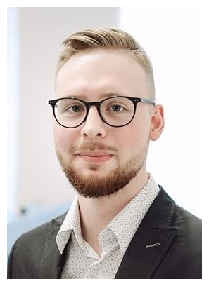

In [8]:
open_image(img_names[0]).show(figsize=(5,5))

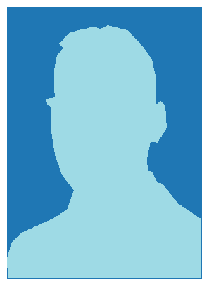

In [9]:
open_mask(get_y_fn(img_names[0])).show(figsize=(5,5), alpha=1)

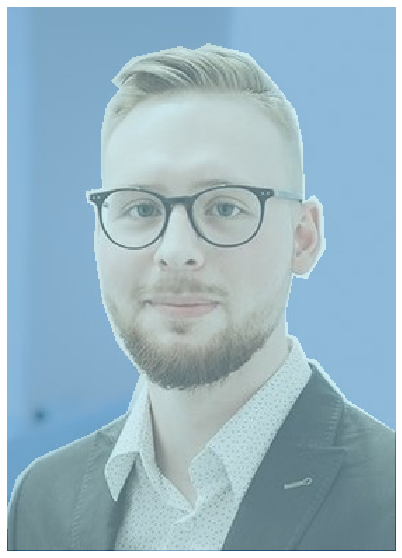

In [10]:
img = open_image(img_names[0])
mask = open_mask(get_y_fn(img_names[0]))
img.show(y=mask, figsize=(10,10))

In [11]:
# opencv <-> fastai Image funcs
img2np = lambda im: image2np(im.data.float()*255).astype(np.uint8)
def img2np(im):
    mult = 1. if type(im) == ImageSegment else 255.
    return image2np(im.data.float()*mult).astype(np.uint8)

def np2img(im, Class=Image):
    if len(im.shape) == 2: im = im[:,:,None]
    mult = 1. if Class == ImageSegment else 255.
    return Class(tensor(im).float().permute(2,0,1)/mult)

In [12]:
print(mask.shape, img.shape)
np_mask, np_img = img2np(mask), img2np(img)
print(np_mask.shape, np_img.shape)
mask, img = np2img(np_mask, Class=ImageSegment), np2img(np_img, Class=Image)
print(mask.shape, img.shape)

torch.Size([1, 388, 277]) torch.Size([3, 388, 277])
(388, 277) (388, 277, 3)
torch.Size([1, 388, 277]) torch.Size([3, 388, 277])


#### Face and Eye detector

more cascades:  
http://alereimondo.no-ip.org/OpenCV/34  
https://github.com/opencv/opencv/tree/master/data/haarcascades

In [13]:
face_cascade = cv2.CascadeClassifier()
face_cascade.load(cv2.samples.findFile('haarcascades/haarcascade_frontalface_default.xml'))
# face_cascade.load(cv2.samples.findFile('haarcascades/haarcascade_profileface.xml'))
eyes_cascade = cv2.CascadeClassifier()
eyes_cascade.load(cv2.samples.findFile('haarcascades/haarcascade_eye_tree_eyeglasses.xml'))
# eyes_cascade.load(cv2.samples.findFile('haarcascades/haarcascade_eye.xml'))
# eyes_cascade.load(cv2.samples.findFile('haarcascades/haarcascade_righteye_2splits.xml'))
# eyes_cascade.load(cv2.samples.findFile('haarcascades/haarcascade_lefteye_2splits.xml'))
smile_cascade = cv2.CascadeClassifier()
smile_cascade.load(cv2.samples.findFile('haarcascades/haarcascade_smile.xml'))

True

In [14]:
def cascade_detect_regions(img, cascade_classifier):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.equalizeHist(img_gray)
    regions = cascade_classifier.detectMultiScale(img_gray)
    return [ (t,l,t+h,l+w) for (l,t,w,h) in regions] # out: (t,l,b,r)

In [15]:
detect_faces = lambda img: cascade_detect_regions(img, face_cascade)
detect_eyes = lambda img: cascade_detect_regions(img, eyes_cascade)
detect_smiles = lambda img: cascade_detect_regions(img, smile_cascade)

In [16]:
def show_cascade_example(img, cascade_func=detect_faces):
    out = np.zeros_like(img)
    for t,l,b,r in cascade_func(img):
        out[t:b , l:r] = img[t:b , l:r]
    return np2img(out).show()

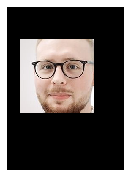

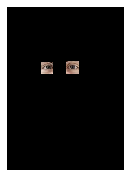

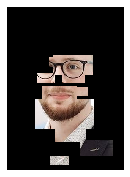

In [17]:
img = img2np(img)
show_cascade_example(img, detect_faces)
show_cascade_example(img, detect_eyes)
show_cascade_example(img, detect_smiles)

### testing

In [18]:
resize_img = lambda im, size: im.resize((im.data.shape[0], size[0], size[1]))

In [19]:
def get_random_np_img_and_mask(size=(600,400)):
    im_fn = random.choice(list(path_img.iterdir()))
    img, mask_true = open_image(im_fn), open_mask(get_y_fn(im_fn))
    img, mask_true = resize_img(img, size), resize_img(mask_true, size)
    return img2np(img), img2np(mask_true)

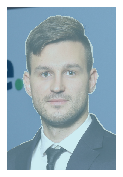

In [20]:
img, mask = get_random_np_img_and_mask()
np2img(img).show(y=np2img(mask, Class=ImageSegment))

In [21]:
def acc(y_pred, y_true): # torch tensors w/ shape [b,h,w]
    return (y_pred == y_true).float().mean()

In [22]:
from sklearn.metrics import confusion_matrix

In [23]:
torch.ones(10,10,10).sum(dim=(0,1,2))

tensor(1000.)

In [24]:
def recall(y_pred, y_true):
    bs = y_pred.shape[0]
    y_pred, y_true = y_pred.view(bs,-1).long(), y_true.view(bs,-1).long()
    return ((y_pred * y_true).sum(1).float() / y_true.sum(1).float()).mean()

In [25]:
def test_algorithm(f, metrics=[acc,recall], size=(600,400), progress=False):
    # f = f(img[h,w,3], mask_true[h,w]) -> mask_pred[h,w] (numpy arrays), (mask: 0-bg, 1-fg)
    img_paths = list(path_img.iterdir())
    mask_preds, mask_trues = torch.zeros(len(img_paths), *size), torch.zeros(len(img_paths), *size)
    if progress: img_paths = progress_bar(img_paths)
    for i,im_fn in enumerate(img_paths):
        img, mask_true = open_image(im_fn), open_mask(get_y_fn(im_fn))
        img, mask_true = resize_img(img, size), resize_img(mask_true, size)
        np_img, np_mask_true = img2np(img), img2np(mask_true) # normalize to: 0-bg, 1-fg
        np_mask_pred = f(np_img, np_mask_true)
        mask_preds[i] = tensor(np_mask_pred)
        mask_trues[i] = tensor(np_mask_true)
    return tensor([ m(mask_preds, mask_trues) for m in metrics ])

In [203]:
def show_worse_results(f, num_items, metric_func=acc, size=(600,400), progress=False, figsize=None, imgsize=4, title='worse results'):
    # f = f(img[h,w,3], mask_true[h,w]) -> mask_pred[h,w] (numpy arrays), (mask: 0-bg, 1-fg)
    img_paths = list(path_img.iterdir())
    mask_preds, mask_trues = torch.zeros(len(img_paths), *size), torch.zeros(len(img_paths), *size)
    if progress: iter_img_paths = progress_bar(img_paths)
    results = []
    for i,im_fn in enumerate(iter_img_paths):
        img, mask_true = open_image(im_fn), open_mask(get_y_fn(im_fn))
        img, mask_true = resize_img(img, size), resize_img(mask_true, size)
        np_img, np_mask_true = img2np(img), img2np(mask_true)
        np_mask_pred = f(np_img, np_mask_true)
        mask_pred = tensor(np_mask_pred)
        mask_true = tensor(np_mask_true)
        results.append( metric_func(mask_pred[None], mask_true[None]) )
        
    axs = subplots(num_items, 3, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=12)
    for i_ax, (i,res) in enumerate(sorted(enumerate(results), key=lambda x:x[1])[:num_items]):
        im_fn = img_paths[i]
        img, mask_true = open_image(im_fn), open_mask(get_y_fn(im_fn))
        img, mask_true = resize_img(img, size), resize_img(mask_true, size)
        np_img, np_mask_true = img2np(img), img2np(mask_true)
        mask_pred = f(np_img, np_mask_true)
        img.show(ax=axs[i_ax,0], title='y_pred', y=np2img(mask_pred, Class=ImageSegment))
        np2img(mask_pred).show(ax=axs[i_ax,1], title=f'res: {res}')
        img.show(ax=axs[i_ax,2], title='y_true', y=mask_true)

In [27]:
return_true_mask = lambda img, mask_true: mask_true
test_algorithm(return_true_mask)

tensor([1., 1.])

In [28]:
return_random_mask = lambda img, mask_true: np.random.randint(0,2, size=mask_true.shape, dtype=np.uint8)
test_algorithm(return_random_mask)

tensor([0.5002, 0.5002])

In [29]:
return_zero_mask = lambda img, mask_true: np.zeros(mask_true.shape, dtype=np.uint8)
test_algorithm(return_zero_mask)

tensor([0.3833, 0.0000])

In [30]:
return_ones_mask = lambda img, mask_true: np.ones(mask_true.shape, dtype=np.uint8)
test_algorithm(return_ones_mask)

tensor([0.6167, 1.0000])

### Grab Cut

In [298]:
img, mask = get_random_np_img_and_mask()

#### grab cut naked

In [32]:
def grab_cut_naked(img, _):
    h,w,c = img.shape
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    rect = (0,0,h,w)
    mask = np.zeros(img.shape[:2],np.uint8)
    mask, bgdModel, fgdModel = cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
    return np.where((mask==2)|(mask==0),0,1).astype('uint8')

In [33]:
%%timeit
grab_cut_naked(img, mask)

2.6 s ± 369 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
test_algorithm(grab_cut_naked, progress=True)

tensor([0.3899, 0.4750])

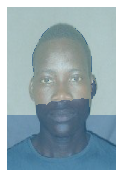

In [35]:
np2img(img).show(y=np2img(grab_cut_naked(img, mask), Class=ImageSegment))

#### grab cut with side bg mask and middle pixels as fg

In [129]:
def find_bg_only_regions(size=(600,400)): # 1's - bg only regions
    bg_mask = np.ones(size, dtype=bool)
    for im_fn in path_img.iterdir():
        mask = open_mask(get_y_fn(im_fn))
        mask = resize_img(mask, size)
        np_mask = 1. - img2np(mask)
        bg_mask *= np_mask.astype(bool)
    return bg_mask.astype(np.uint8)

(tensor([0, 1], dtype=torch.uint8), tensor([202793,  37207]))

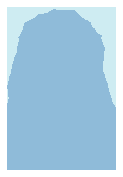

In [130]:
bg_mask = find_bg_only_regions()
np2img(bg_mask, Class=ImageSegment).show()
tensor(bg_mask).unique(return_counts=True)

In [311]:
def grab_cut_bg_mask(img, _, pad=10, iters=5, be_sure=True):
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    mask = bg_mask.copy()
    mask[bg_mask == 1] = cv2.GC_BGD
    mask[bg_mask == 0] = cv2.GC_PR_FGD
    mask, bgdModel, fgdModel = cv2.grabCut(img,mask,None,bgdModel,fgdModel,iters,cv2.GC_INIT_WITH_MASK)
    return mask if not be_sure else np.where((mask==cv2.GC_PR_BGD)|(mask==cv2.GC_BGD),0,1).astype('uint8')

In [40]:
test_algorithm(grab_cut_bg_mask, progress=True)

tensor([0.9431, 0.9650])

In [64]:
cv2.GC_BGD, cv2.GC_FGD, cv2.GC_PR_BGD, cv2.GC_PR_FGD

(0, 1, 2, 3)

(tensor([0, 2, 3], dtype=torch.uint8), tensor([ 37207,  51105, 151688]))

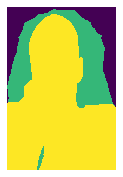

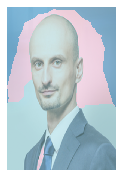

In [65]:
mask_pred = grab_cut_bg_mask(img, mask, be_sure=False)
np2img(mask_pred, Class=Image).show()
np2img(img).show(y=np2img(mask_pred, Class=ImageSegment))
tensor(mask_pred).unique(return_counts=True)

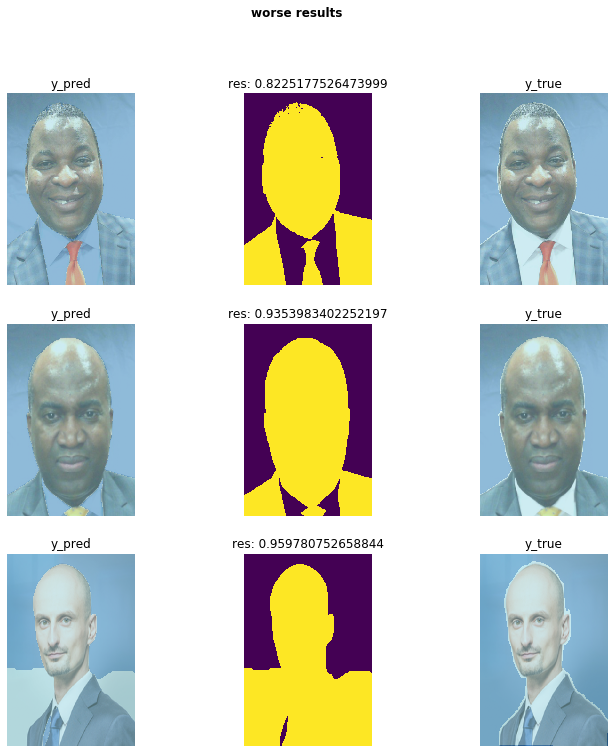

In [204]:
show_worse_results(grab_cut_bg_mask, 3, progress=True, metric_func=recall)

#### Same just mask fg is found by face, eye detector

In [314]:
def grab_cut_face_mask(img, _, face_pct=.4, eyes_pct=1.3, iters=5, be_sure=True, ksize=15):
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
#     mask = bg_mask.copy()
#     mask[bg_mask == 1] = cv2.GC_BGD
#     mask[bg_mask == 0] = cv2.GC_PR_FGD
    mask = comp_mask.copy()
    mask[comp_mask == comp_mask_BG] = cv2.GC_BGD
    mask[comp_mask == comp_mask_FG] = cv2.GC_FGD
    mask[comp_mask == comp_mask_PR_BG] = cv2.GC_PR_BGD
    mask[comp_mask == comp_mask_PR_FG] = cv2.GC_PR_FGD

    # put faces and eyes in mask
    eyes = detect_eyes(img)
    faces = detect_faces(img)
    for pct, regions in [(face_pct,faces),(eyes_pct,eyes)]:
        for t,l,b,r in regions:
            h,w = b-t,r-l
            h_pad, w_pad = (h-int(pct*h))//2, (w-int(pct*w))//2
            t,l,b,r = t+h_pad,l+w_pad,b-h_pad,r-w_pad
            mask[t:b , l:r] = cv2.GC_FGD
    mask, bgdModel, fgdModel = cv2.grabCut(img,mask,None,bgdModel,fgdModel,iters,cv2.GC_INIT_WITH_MASK)
    if be_sure:
        mask = np.where((mask==cv2.GC_PR_BGD)|(mask==cv2.GC_BGD),0,1).astype('uint8')
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((ksize,ksize),np.uint8))
    return mask

In [315]:
%%timeit
grab_cut_face_mask(img, mask)

577 ms ± 4.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


(tensor([0, 1, 2, 3], dtype=torch.uint8),
 tensor([ 37207,  17501,  12414, 172878]))

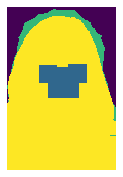

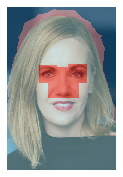

In [136]:
mask_pred = grab_cut_face_mask(img, mask, be_sure=False)
np2img(mask_pred, Class=Image).show()
np2img(img).show(y=np2img(mask_pred, Class=ImageSegment))
tensor(mask_pred).unique(return_counts=True)

In [262]:
test_algorithm(grab_cut_face_mask, progress=True)

tensor([0.9522, 0.9724])

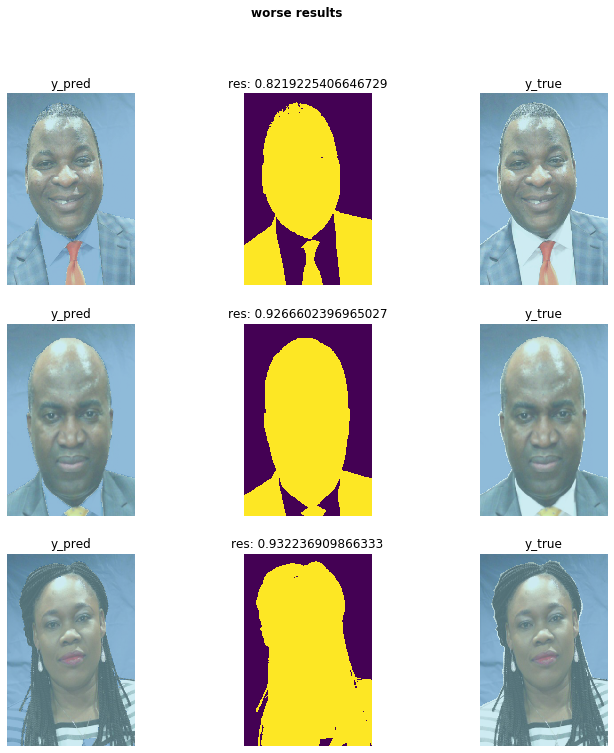

In [205]:
show_worse_results(grab_cut_face_mask, 3, progress=True, metric_func=recall)

#### fg and bg are chosen from only fg/bg regions

In [138]:
def find_fg_only_regions(size=(600,400)): # 1's - bg only regions
    bg_mask = np.ones(size, dtype=bool)
    for im_fn in path_img.iterdir():
        mask = open_mask(get_y_fn(im_fn))
        mask = resize_img(mask, size)
        np_mask = img2np(mask)
        bg_mask = bg_mask * np_mask.astype(bool)
    return bg_mask.astype(np.uint8)

In [139]:
fg_mask = find_fg_only_regions()
tensor(fg_mask).unique(return_counts=True)

(tensor([0, 1], dtype=torch.uint8), tensor([150711,  89289]))

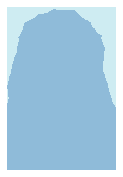

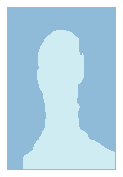

In [140]:
np2img(bg_mask, Class=ImageSegment).show()
np2img(fg_mask, Class=ImageSegment).show()

In [308]:
def grab_cut_bg_fg_mask(img, _, iters=5, be_sure=True, bg_true=cv2.GC_BGD, fg_true=cv2.GC_FGD, other_area=cv2.GC_PR_FGD):
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    mask = bg_mask.copy()
    mask[bg_mask == 0] = other_area
    mask[bg_mask == 1] = bg_true
    mask[fg_mask == 1] = fg_true
    mask, bgdModel, fgdModel = cv2.grabCut(img,mask,None,bgdModel,fgdModel,iters,cv2.GC_INIT_WITH_MASK)
    return mask if not be_sure else np.where((mask==cv2.GC_PR_BGD)|(mask==cv2.GC_BGD),0,1).astype('uint8')

In [98]:
f = partial(grab_cut_bg_fg_mask, bg_true=cv2.GC_BGD, fg_true=cv2.GC_FGD, other_area=cv2.GC_PR_FGD)
test_algorithm(f, progress=True)

torch.Size([20, 600, 400]) torch.Size([20, 600, 400])


tensor([0.9544, 0.9787])

In [100]:
f = partial(grab_cut_bg_fg_mask, bg_true=cv2.GC_BGD, fg_true=cv2.GC_PR_FGD, other_area=cv2.GC_PR_BGD)
test_algorithm(f, progress=True)

torch.Size([20, 600, 400]) torch.Size([20, 600, 400])


tensor([0.8803, 0.8195])

(tensor([0, 1, 2, 3], dtype=torch.uint8), tensor([37207, 89289, 43594, 69910]))

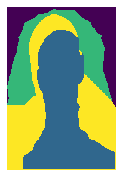

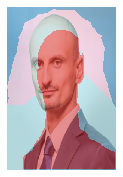

In [101]:
mask_pred = grab_cut_bg_fg_mask(img, mask, be_sure=False)
np2img(mask_pred, Class=Image).show()
np2img(img).show(y=np2img(mask_pred, Class=ImageSegment))
tensor(mask_pred).unique(return_counts=True)

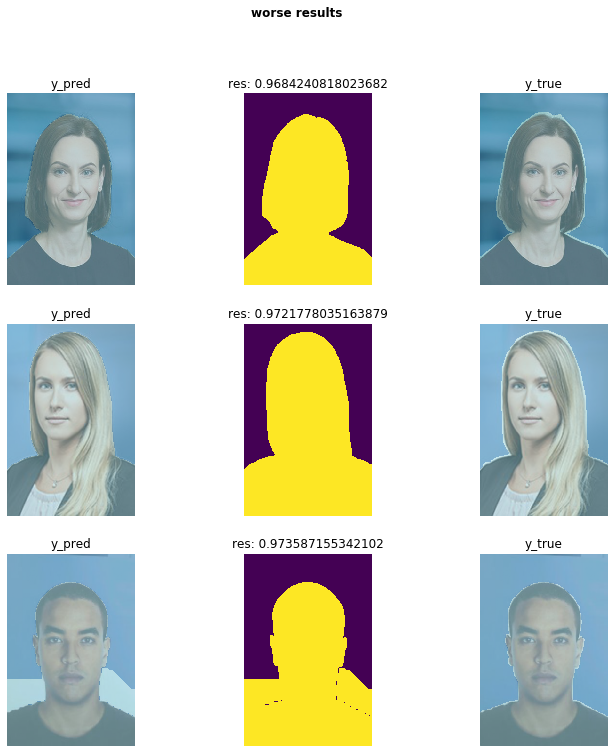

In [206]:
show_worse_results(grab_cut_bg_fg_mask, 3, progress=True, metric_func=recall)

#### manually created mask

In [143]:
def kmeans(img, K=4, iters=10, epsilon=1.0):
    Z = img.reshape((-1,img.shape[-1])).astype(np.float32)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, iters, epsilon)
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    return center.astype(np.uint8)[label.flatten()].reshape(img.shape)

In [144]:
def prep_paint_mask(in_im=path/'masks'/'paint_original.png', out_im=path/'masks'/'paint.png'):
    img = cv2.imread(str(in_im))
    img = kmeans(img, K=4, iters=100)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = np.zeros_like(img)
    print('K:', len(np.unique(img)))
    for i,px in enumerate(np.unique(img)):
        mask[img == px] = i
    new_mask = np2img(mask, Class=ImageSegment)
    new_mask.save(out_im)
    new_mask.show()
    return out_im

In [258]:
def grab_cut_custom_mask(img, _, iters=5, be_sure=True, dilate=False, ksize=15):
    assert comp_mask.shape == img.shape[:2]
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    mask = comp_mask.copy()
    mask[comp_mask == comp_mask_BG] = cv2.GC_BGD
    mask[comp_mask == comp_mask_FG] = cv2.GC_FGD
    mask[comp_mask == comp_mask_PR_BG] = cv2.GC_PR_BGD
    mask[comp_mask == comp_mask_PR_FG] = cv2.GC_PR_FGD
    mask, bgdModel, fgdModel = cv2.grabCut(img,mask,None,bgdModel,fgdModel,iters,cv2.GC_INIT_WITH_MASK)
    if be_sure:
        mask = np.where((mask==cv2.GC_PR_BGD)|(mask==cv2.GC_BGD),0,1).astype('uint8')
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((ksize,ksize),np.uint8))
    if dilate: mask[dilate_mask(mask, iters=5, max_val=.6) > 0.3 ] = 1
    return mask

In [181]:
in_mask_path = path/'masks'/'paint_original.png'
comp_mask_path = path/'masks'/'paint.png'
# prep_paint_mask(in_mask_path, comp_mask_path)
comp_mask_BG, comp_mask_FG = 0, 3
comp_mask_PR_BG, comp_mask_PR_FG = 1, 2
comp_mask = open_mask(comp_mask_path)
comp_mask = resize_img(comp_mask, (600,400))
comp_mask.data.unique(return_counts=True)
comp_mask = img2np(comp_mask)

In [182]:
test_algorithm(grab_cut_custom_mask, progress=True)

tensor([0.9286, 0.8957])

In [183]:
in_mask_path = path/'masks'/'paint2_original.png'
comp_mask_path = path/'masks'/'paint2.png'
# prep_paint_mask(in_mask_path, comp_mask_path)
comp_mask_BG, comp_mask_FG = 0, 3
comp_mask_PR_BG, comp_mask_PR_FG = 1, 2
comp_mask = open_mask(comp_mask_path)
comp_mask = resize_img(comp_mask, (600,400))
comp_mask.data.unique(return_counts=True)
comp_mask = img2np(comp_mask)

In [184]:
test_algorithm(grab_cut_custom_mask, progress=True)

tensor([0.9422, 0.9237])

In [246]:
in_mask_path = path/'masks'/'paint3_original.png'
comp_mask_path = path/'masks'/'paint3.png'
# prep_paint_mask(in_mask_path, comp_mask_path)
comp_mask_BG, comp_mask_FG = 0, 3
comp_mask_PR_BG, comp_mask_PR_FG = 1, 2
comp_mask = open_mask(comp_mask_path)
comp_mask = resize_img(comp_mask, (600,400))
comp_mask.data.unique(return_counts=True)
comp_mask = img2np(comp_mask)

In [247]:
test_algorithm(grab_cut_custom_mask, progress=True)

tensor([0.9545, 0.9649])

In [322]:
in_mask_path = path/'masks'/'paint4_original.png'
comp_mask_path = path/'masks'/'paint4.png'
# prep_paint_mask(in_mask_path, comp_mask_path)
comp_mask_BG, comp_mask_FG = 0, 3
comp_mask_PR_BG, comp_mask_PR_FG = 1, 2
comp_mask = open_mask(comp_mask_path)
comp_mask = resize_img(comp_mask, (600,400))
comp_mask.data.unique(return_counts=True)
comp_mask = img2np(comp_mask)

In [260]:
test_algorithm(grab_cut_custom_mask, progress=True)

tensor([0.9509, 0.9729])

In [313]:
%%timeit
grab_cut_custom_mask(img, mask)

500 ms ± 11.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [225]:
test_algorithm(partial(grab_cut_custom_mask, dilate=True), progress=True)

tensor([0.8650, 0.9985])

(tensor([0, 1, 2, 3], dtype=torch.uint8),
 tensor([ 26384,  48510,  52835, 112271]))

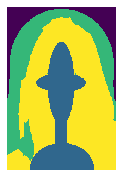

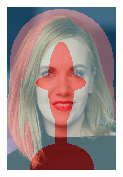

In [194]:
mask_pred = grab_cut_custom_mask(img, mask, be_sure=False)
np2img(mask_pred, Class=Image).show()
np2img(img).show(y=np2img(mask_pred, Class=ImageSegment))
tensor(mask_pred).unique(return_counts=True)

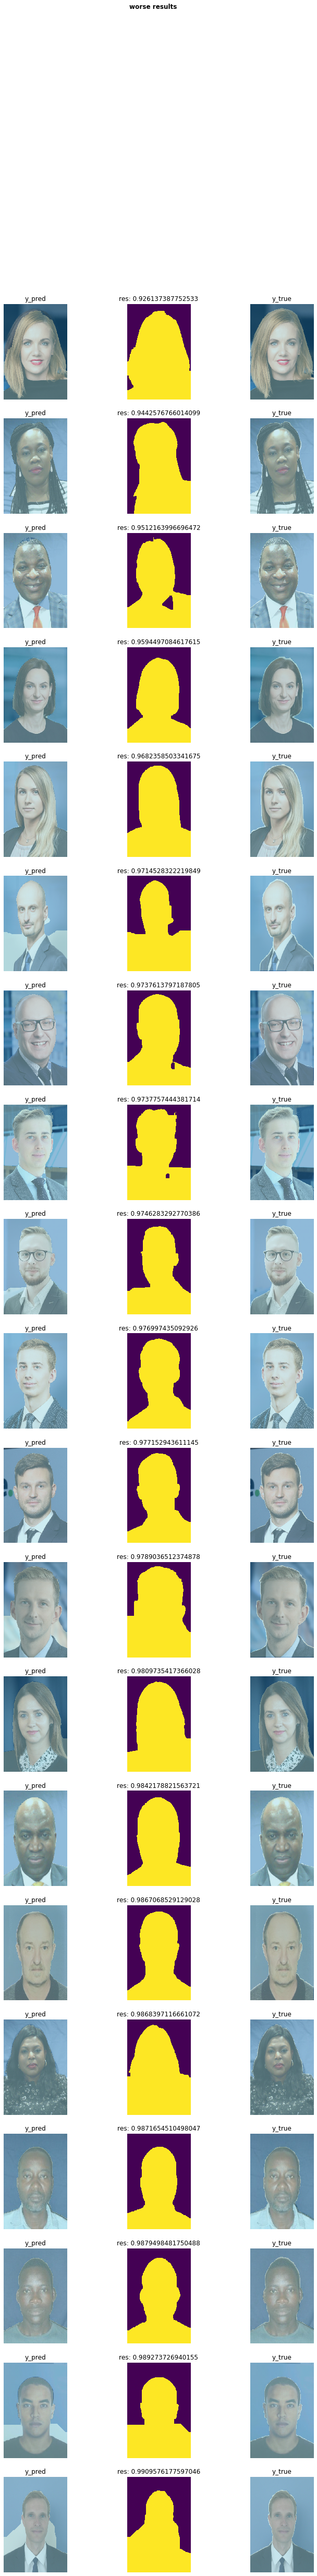

In [226]:
show_worse_results(grab_cut_custom_mask, 20, progress=True, metric_func=recall)

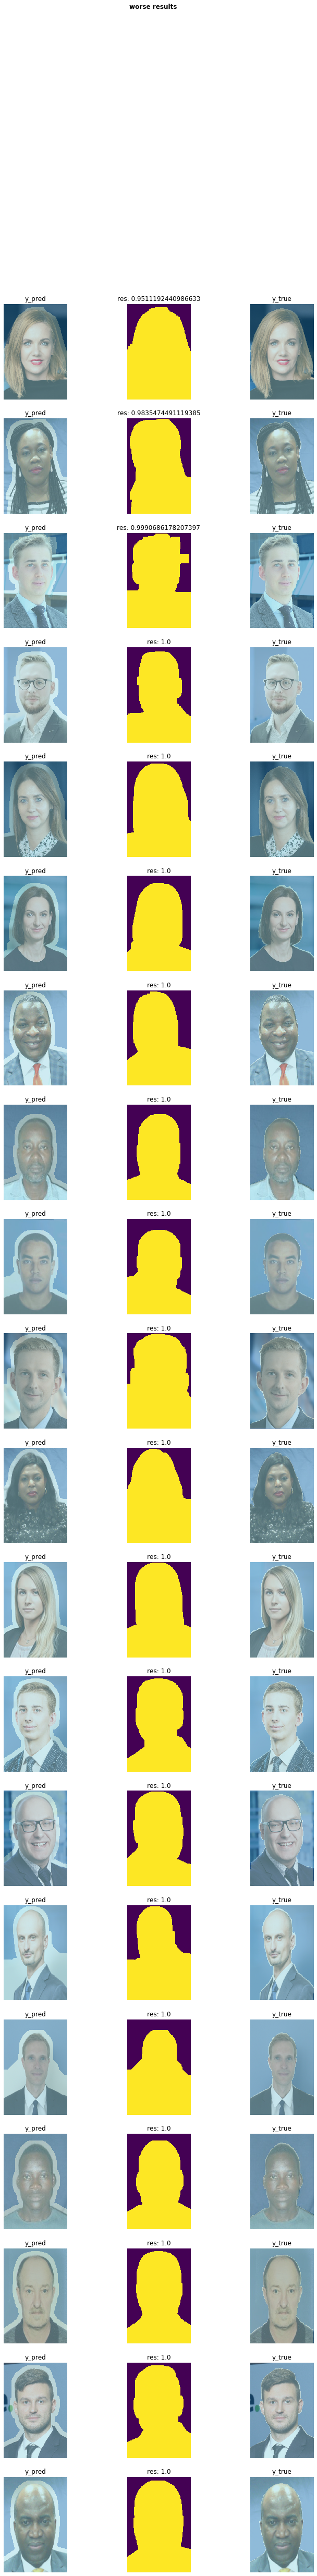

In [214]:
show_worse_results(partial(grab_cut_custom_mask, dilate=True), 20, progress=True, metric_func=recall)

#### U-Net

In [50]:
defaults.device = torch.device('cpu')
learner = load_learner('models/', file='unet.pkl')

In [342]:
resize_one_img = lambda x, size: F.interpolate(x[None], size=size, mode='bilinear', align_corners=True)[0]

def unet_classifier(img, _, ksize=15):
    img = np2img(img)
    img = resize_img(img, tensor([720, 960])//2)
    seg, *_ = learner.predict(img)
    mask = resize_one_img(seg.data.float(), (600,400))
    mask = img2np(ImageSegment(mask))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((ksize,ksize),np.uint8))
    return mask

In [344]:
%%timeit
mask_pred = unet_classifier(img, mask)

486 ms ± 4.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [343]:
test_algorithm(unet_classifier, progress=True)

tensor([0.9754, 0.9649])

(tensor([0, 1], dtype=torch.uint8), tensor([ 86679, 153321]))

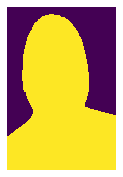

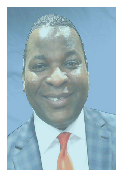

In [118]:
img, mask = get_random_np_img_and_mask()
mask_pred = unet_classifier(img, mask)
np2img(mask_pred, Class=Image).show()
np2img(img).show(y=np2img(mask_pred, Class=ImageSegment))
tensor(mask_pred).unique(return_counts=True)

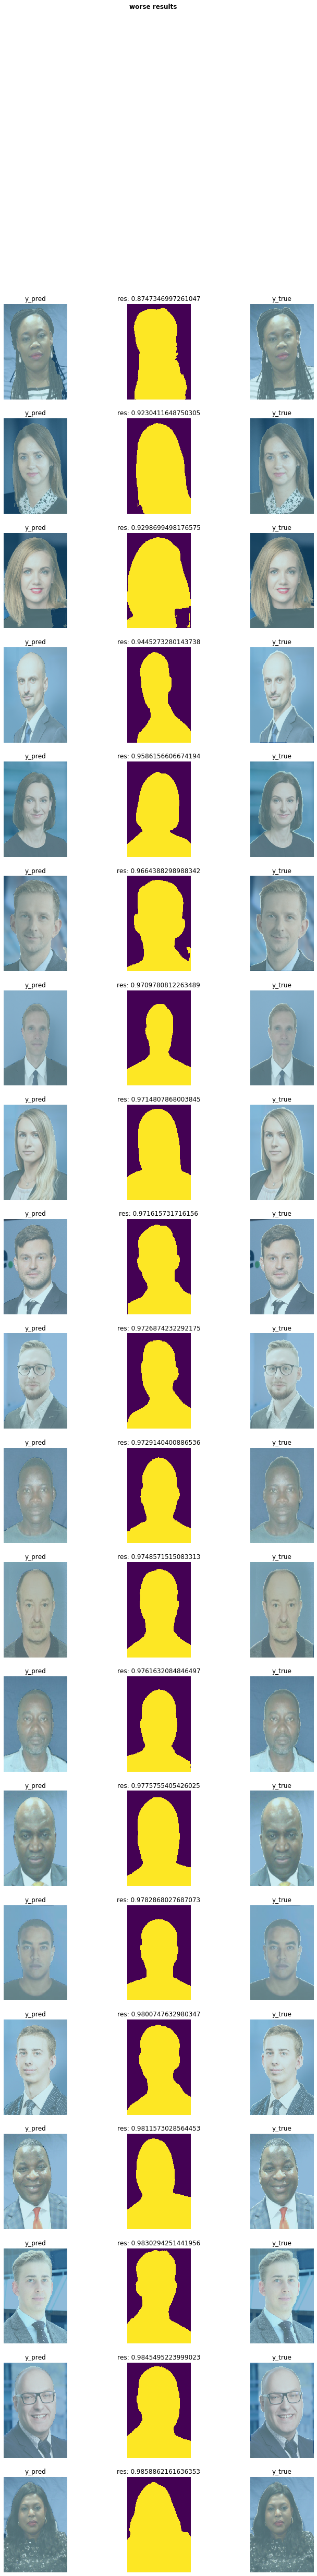

In [213]:
show_worse_results(unet_classifier, 20, progress=True, metric_func=recall)

#### unet + grabcut

In [335]:
def grab_cut_unet(img, _, iters=5, be_sure=True, dilate=False, ksize=15):
    unet_mask = unet_classifier(img, _)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    mask = unet_mask.copy()
    mask[comp_mask == comp_mask_BG] = cv2.GC_BGD
    mask[unet_mask == 0] = cv2.GC_PR_BGD
    mask[unet_mask == 1] = cv2.GC_FGD
    mask, bgdModel, fgdModel = cv2.grabCut(img,mask,None,bgdModel,fgdModel,iters,cv2.GC_INIT_WITH_MASK)
    if be_sure:
        mask = np.where((mask==cv2.GC_PR_BGD)|(mask==cv2.GC_BGD),0,1).astype('uint8')
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((ksize,ksize),np.uint8))
    if dilate: mask[dilate_mask(mask, iters=5, max_val=.6) > 0.3 ] = 1
    return mask

In [336]:
%%timeit
grab_cut_unet(img, mask)

848 ms ± 25.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


(tensor([0, 1], dtype=torch.uint8), tensor([ 45649, 194351]))

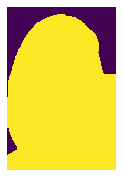

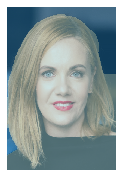

In [272]:
# img, mask = get_random_np_img_and_mask()
mask_pred = grab_cut_unet(img, mask)
np2img(mask_pred, Class=Image).show()
np2img(img).show(y=np2img(mask_pred, Class=ImageSegment))
tensor(mask_pred).unique(return_counts=True)

In [337]:
test_algorithm(grab_cut_unet, progress=True)

tensor([0.9800, 0.9751])

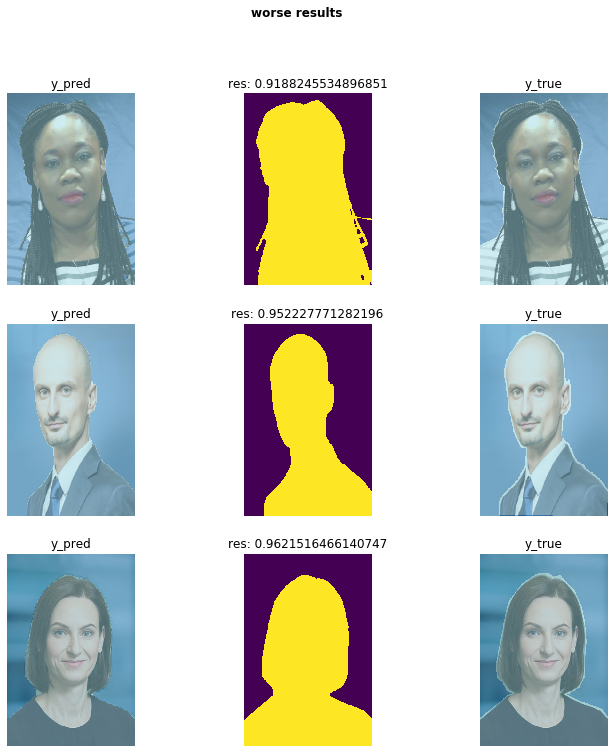

In [212]:
show_worse_results(grab_cut_unet, 3, progress=True, metric_func=recall)

### Saliency

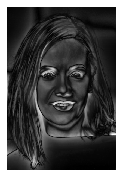

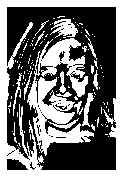

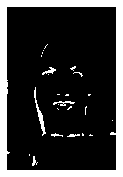

In [86]:
# img, mask = get_random_np_img_and_mask()
saliency = cv2.saliency.StaticSaliencyFineGrained_create()
(success, saliencyMap) = saliency.computeSaliency(img)

np2img(np.repeat(saliencyMap[:,:,None], 3, 2)*255, Class=Image).show()
np2img((np.repeat(saliencyMap[:,:,None], 3, 2)>0.2)*255, Class=Image).show()
np2img((np.repeat(saliencyMap[:,:,None], 3, 2)>0.5)*255, Class=Image).show()

In [316]:
def grab_cut_saliency(img, _, iters=5, be_sure=True, dilate=False, ksize=15):
    saliency = cv2.saliency.StaticSaliencyFineGrained_create()
    (success, saliencyMap) = saliency.computeSaliency(img)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    mask = comp_mask.copy()
    mask[comp_mask == comp_mask_BG] = cv2.GC_BGD
    mask[comp_mask == comp_mask_FG] = cv2.GC_FGD
    mask[comp_mask == comp_mask_PR_BG] = cv2.GC_PR_BGD
    mask[comp_mask == comp_mask_PR_FG] = cv2.GC_PR_FGD
    mask[saliencyMap > 0.6] = cv2.GC_PR_FGD
    mask[saliencyMap > 1.0] = cv2.GC_FGD
    mask, bgdModel, fgdModel = cv2.grabCut(img,mask,None,bgdModel,fgdModel,iters,cv2.GC_INIT_WITH_MASK)
    if be_sure:
        mask = np.where((mask==cv2.GC_PR_BGD)|(mask==cv2.GC_BGD),0,1).astype('uint8')
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((ksize,ksize),np.uint8))
    if dilate: mask[dilate_mask(mask, iters=5) > 0.3 ] = 1
    return mask

In [317]:
%%timeit
grab_cut_saliency(img, mask)

523 ms ± 3.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [327]:
def grab_cut_saliency_face(img, _, iters=5, be_sure=True, dilate=False, ksize=15,face_pct=.4, eyes_pct=1.3):
    saliency = cv2.saliency.StaticSaliencyFineGrained_create()
    (success, saliencyMap) = saliency.computeSaliency(img)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    mask = comp_mask.copy()
    mask[comp_mask == comp_mask_BG] = cv2.GC_BGD
    mask[comp_mask == comp_mask_FG] = cv2.GC_FGD
    mask[comp_mask == comp_mask_PR_BG] = cv2.GC_PR_BGD
    mask[comp_mask == comp_mask_PR_FG] = cv2.GC_PR_FGD
    # put faces and eyes in mask
    eyes = detect_eyes(img)
    faces = detect_faces(img)
    for pct, regions in [(face_pct,faces),(eyes_pct,eyes)]:
        for t,l,b,r in regions:
            h,w = b-t,r-l
            h_pad, w_pad = (h-int(pct*h))//2, (w-int(pct*w))//2
            t,l,b,r = t+h_pad,l+w_pad,b-h_pad,r-w_pad
            mask[t:b , l:r] = cv2.GC_FGD
    # saliency
    mask[saliencyMap > 0.6] = cv2.GC_PR_FGD
    mask[saliencyMap > 1.0] = cv2.GC_FGD
    mask, bgdModel, fgdModel = cv2.grabCut(img,mask,None,bgdModel,fgdModel,iters,cv2.GC_INIT_WITH_MASK)
    if be_sure:
        mask = np.where((mask==cv2.GC_PR_BGD)|(mask==cv2.GC_BGD),0,1).astype('uint8')
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((ksize,ksize),np.uint8))
    if dilate: mask[dilate_mask(mask, iters=5) > 0.3 ] = 1
    return mask

In [321]:
%%timeit
grab_cut_saliency_face(img, mask)

605 ms ± 3.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [325]:
test_algorithm(grab_cut_saliency, progress=True)

tensor([0.9531, 0.9730])

In [328]:
test_algorithm(grab_cut_saliency_face, progress=True)

tensor([0.9531, 0.9736])

(tensor([0, 1], dtype=torch.uint8), tensor([ 60534, 179466]))

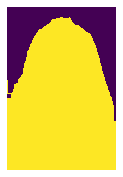

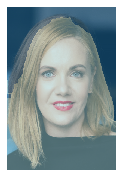

In [270]:
# img, mask = get_random_np_img_and_mask()
mask_pred = grab_cut_saliency(img, mask)
np2img(mask_pred, Class=Image).show()
np2img(img).show(y=np2img(mask_pred, Class=ImageSegment))
tensor(mask_pred).unique(return_counts=True)

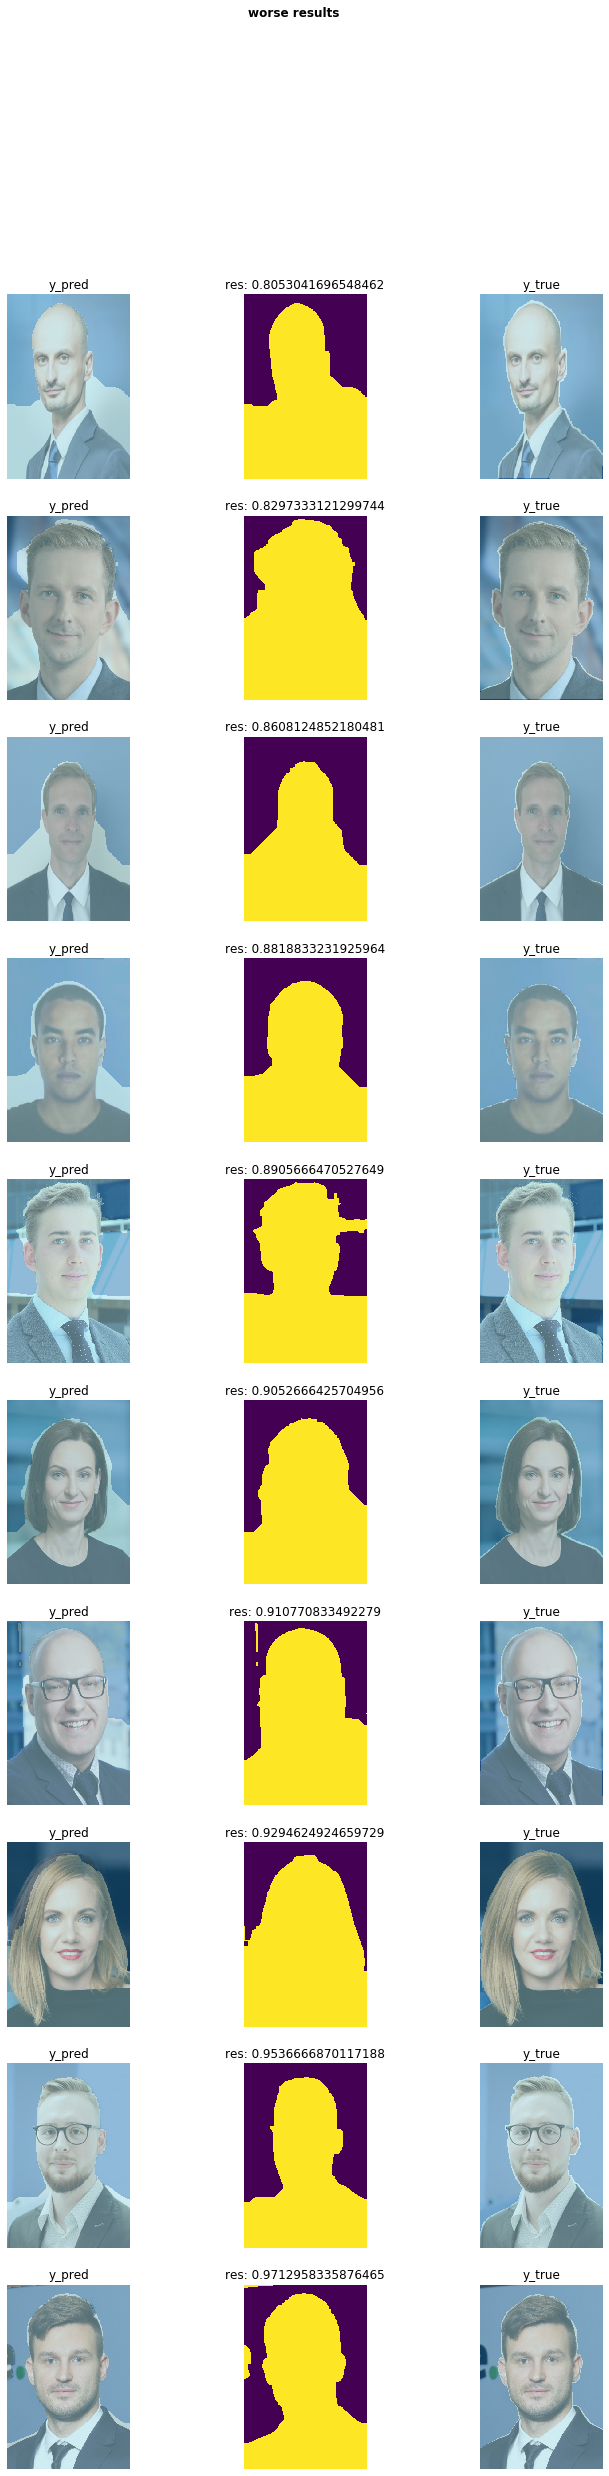

In [269]:
show_worse_results(grab_cut_saliency, 10, progress=True, metric_func=acc)

## Output

In [158]:
def dilate_mask(mask, iters=10, max_val=1., k=15):
    kernel = np.ones((k,k), np.uint8)
    out_mask = np.zeros_like(mask)
    out_mask = out_mask + mask*(1-max_val)
    for i in range(iters):
        mask = cv2.dilate(mask, kernel=kernel, iterations=1)
        out_mask = out_mask + mask*(max_val/iters)
    return np.clip(out_mask, 0, 1)

In [159]:
def apply_mask(img, mask, bg_num=255.):
    # img [h,w,3], mask[h,w] of floats [0-1], where 1-fg, 0-bg, (0-1)-transparent
    # return img w/ bg_num on bg_mask and img on fg_mask
    mask = mask[:,:,None]
    return img*mask + bg_num*(1.-mask)

In [ ]:
# img, mask = get_random_np_img_and_mask()
mask_pred = grab_cut_unet(img, mask)
np2img(mask_pred, Class=Image).show()
np2img(img).show(y=np2img(mask_pred, Class=ImageSegment))
tensor(mask_pred).unique(return_counts=True)

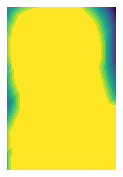

In [204]:
np2img(dilate_mask(mask), Class=Image).show()

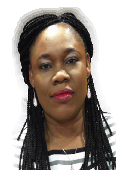

In [213]:
# img, mask = get_random_np_img_and_mask()
mask = grab_cut_unet(img, None)
mask = dilate_mask(mask, iters=3, max_val=1.)
img_out = apply_mask(img, mask)
np2img(img_out, Class=Image).show()

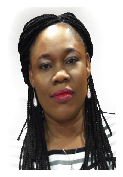

In [223]:
mask = grab_cut_unet(img, None)
mask = dilate_mask(mask, iters=5, max_val=.3)
img_out = apply_mask(img, mask)
np2img(img_out, Class=Image).show()